# Around Black-Scholes

#### Full name: Yaroslav Dunaev
#### Faculty: Mech-mat


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
from scipy.stats import norm
from scipy.optimize import root_scalar

from ipywidgets import interact
from ipywidgets import widgets

from dataclasses import dataclass, field
from typing import Union
from copy import deepcopy

## Episode 1: The Price and It's Derivatives (20 points)

Consider prices of call and put options on stocks in Black-Scholes model:
$$C = S\Phi(d_1) - e^{-rT}K\Phi(d_2), \quad P = e^{-rT}K\Phi(-d_2) - S\Phi(-d_1),$$
where
$$
d_1 = \frac1{\sigma \sqrt{T}} \left( \ln \frac{S}{K} + \left( r + \frac{\sigma^2}2 \right) T \right), \quad 
d_2 = \frac1{\sigma \sqrt{T}} \left( \ln \frac{S}{K} + \left( r - \frac{\sigma^2}2 \right) T \right).
$$
\begin{aligned}
\Delta_c &= \frac{\partial C}{\partial S} = \Phi(d_1)\\
\Delta_p &= \frac{\partial P}{\partial S} = -\Phi(-d_1)\\
\gamma_c &= \frac{\partial^2 C}{\partial S^2} = \frac{\Phi'(d_1)}{S\sigma\sqrt{T}} =-\frac{\frac{e^\frac{{d_1}^2}{2}}{2\pi}}{S\sigma\sqrt{T}} \\
\gamma_p &= \frac{\partial^2 P}{\partial S^2} = \frac{\Phi'(d_1)}{S\sigma\sqrt{T}} =-\frac{\frac{e^\frac{{d_1}^2}{2}}{2\pi}}{S\sigma\sqrt{T}} \\
\theta_c &= -\frac{\partial C}{\partial T} = \frac{S\Phi'(d_1)\sigma}{2\sqrt{T}}+re^{-rT}K\Phi(d_2)\\
\theta_p &= -\frac{\partial P}{\partial T} =\frac{S\Phi'(d_1)\sigma}{2\sqrt{T}}-re^{-rT}K\Phi(d_2)\\
\nu_c &= \frac{\partial C}{\partial \sigma} = S\Phi'(d_1)\sqrt{T}\\
\nu_p &= \frac{\partial P}{\partial \sigma} = S\Phi'(d_1)\sqrt{T}\\
\rho_c &= \frac{\partial C}{\partial r} = Te^{-rT}K\Phi(d_2)\\
\rho_p &= \frac{\partial P}{\partial r} = -Te^{-rT}K\Phi(-d_2)
\end{aligned}

In [2]:
@dataclass
class StockOption:
    strike_price: Union[float, np.ndarray]
    expiration_time: Union[float, np.ndarray]  # in years
    is_call: bool

@dataclass
class CallStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, True)
        

@dataclass
class PutStockOption(StockOption):
    def __init__(self, strike_price, expiration_time):
        super().__init__(strike_price, expiration_time, False)

In [3]:
@dataclass
class MarketState:
    stock_price: Union[float, np.ndarray]
    volatility: Union[float, np.ndarray]  # sigma, annualized
    interest_rate: Union[float, np.ndarray]  # r, assume constant

In [4]:
def price(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    K = option.strike_price
    T = option.expiration_time
    S = state.stock_price
    sigma = state.volatility
    r = state.interest_rate
    is_call = option.is_call 
    d1 = (1/(sigma*np.sqrt(T)))*(np.log(S/K)+(r+(sigma*sigma)/2)*T)
    d2 = (1/(sigma*np.sqrt(T)))*(np.log(S/K)+(r-(sigma*sigma)/2)*T)
    if is_call:
        return S*norm.cdf(d1 , loc = 0 , scale = 1)-np.exp(-r*T)*K*norm.cdf(d2 , loc = 0 , scale = 1)
    else:
        return np.exp(-r*T)*K*norm.cdf(-d2 , loc = 0 , scale = 1) - S*norm.cdf(-d1 , loc = 0 , scale = 1)

def delta(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    K = option.strike_price
    T = option.expiration_time
    S = state.stock_price
    sigma = state.volatility
    r = state.interest_rate
    is_call = option.is_call 
    d1 = (1/(sigma*np.sqrt(T)))*(np.log(S/K)+(r+(sigma*sigma)/2)*T)
    d2 = (1/(sigma*np.sqrt(T)))*(np.log(S/K)+(r-(sigma*sigma)/2)*T)
    if is_call:
        return norm.cdf(d1 , loc = 0 , scale = 1)
    else:
        return -norm.cdf(-d1 , loc = 0 , scale = 1)

def gamma(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    K = option.strike_price
    T = option.expiration_time
    S = state.stock_price
    sigma = state.volatility
    r = state.interest_rate
    is_call = option.is_call 
    d1 = (1/(sigma*np.sqrt(T)))*(np.log(S/K)+(r+(sigma*sigma)/2)*T)
    d2 = (1/(sigma*np.sqrt(T)))*(np.log(S/K)+(r-(sigma*sigma)/2)*T)
    return norm.pdf(d1 , loc = 0 , scale = 1)/(S*sigma*np.sqrt(T))

def theta(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    K = option.strike_price
    T = option.expiration_time
    S = state.stock_price
    sigma = state.volatility
    r = state.interest_rate
    is_call = option.is_call 
    d1 = (1/(sigma*np.sqrt(T)))*(np.log(S/K)+(r+(sigma*sigma)/2)*T)
    d2 = (1/(sigma*np.sqrt(T)))*(np.log(S/K)+(r-(sigma*sigma)/2)*T)
    if is_call:
        return -S*norm.pdf(d1 , loc = 0 , scale = 1)*sigma/2*np.sqrt(T)-r*K*np.exp(-r*T)*norm.cdf(d2 , loc = 0 , scale = 1)
    else:
        return -S*norm.pdf(d1 , loc = 0 , scale = 1)*sigma/2*np.sqrt(T)+r*K*np.exp(-r*T)*norm.cdf(-d2 , loc = 0 , scale = 1)

def vega(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    K = option.strike_price
    T = option.expiration_time
    S = state.stock_price
    sigma = state.volatility
    r = state.interest_rate
    is_call = option.is_call 
    d1 = (1/(sigma*np.sqrt(T)))*(np.log(S/K)+(r+(sigma*sigma)/2)*T)
    d2 = (1/(sigma*np.sqrt(T)))*(np.log(S/K)+(r-(sigma*sigma)/2)*T)
    return S*np.sqrt(T)*norm.pdf(d1 , loc = 0 , scale = 1)

def rho(option: StockOption, state: MarketState) -> Union[float, np.ndarray]:
    K = option.strike_price
    T = option.expiration_time
    S = state.stock_price
    sigma = state.volatility
    r = state.interest_rate
    is_call = option.is_call 
    d1 = (1/(sigma*np.sqrt(T)))*(np.log(S/K)+(r+(sigma*sigma)/2)*T)
    d2 = (1/(sigma*np.sqrt(T)))*(np.log(S/K)+(r-(sigma*sigma)/2)*T)
    if is_call:
        return K*T*np.exp(-r*T)*norm.cdf(d2 , loc = 0 , scale = 1)
    else:
        return -K*T*np.exp(-r*T)*norm.cdf(-d2 , loc = 0 , scale = 1)

In [5]:
strikes = np.linspace(50, 150, 50)
times = np.linspace(1e-15, 2, 50)

calls = CallStockOption(strike_price=strikes.reshape(1, -1),
                        expiration_time=times.reshape(-1, 1))
puts = PutStockOption(strike_price=strikes.reshape(1, -1),
                      expiration_time=times.reshape(-1, 1))

In [6]:
market_state = MarketState(stock_price=100,
                           volatility=0.167,
                           interest_rate=0.1)

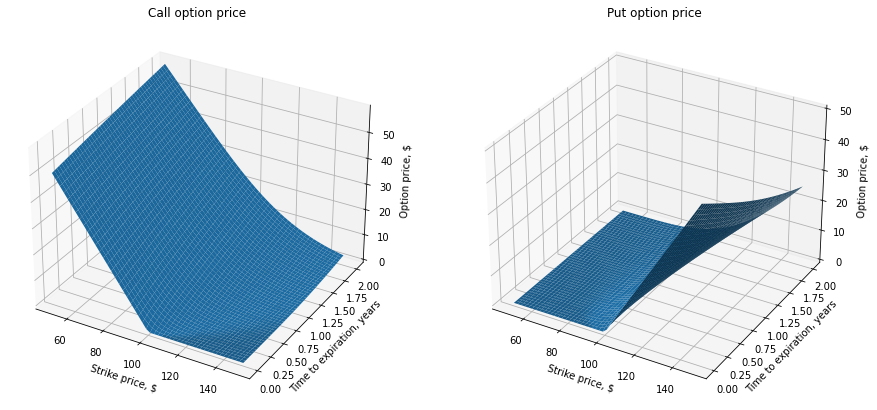

In [7]:
x, y = np.meshgrid(strikes, times)
call_price = price(calls, market_state)
put_price = price(puts, market_state)

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

plt.show()

In [8]:
def plot_all(type_: str = 'Call',
             time_to_expiration: float = 0.25,
             volatility: float = 0.1587,
             stock_price: float = 100.0,
             interest_rate: float = 0.0):
    opt = StockOption(strike_price=np.linspace(20, 200, 100),
                      expiration_time=time_to_expiration,
                      is_call=(type_ == 'Call'))
    state = MarketState(stock_price=stock_price,
                        volatility=volatility,
                        interest_rate=interest_rate)
    
    data = {
        'price': price(opt, state),
        'delta': delta(opt, state),
        'gamma': gamma(opt, state),
        'vega': vega(opt, state),
        'theta': theta(opt, state),
        'rho': rho(opt, state)
    }

    fig, axs = plt.subplots(2, 3, figsize=(20, 10))

    for name, ax in zip(data, axs.flatten()):
        ax.plot(opt.strike_price, data[name])
        ax.set_title(name)
        ax.set_xlabel('Strike price')
        
    plt.show()

In [9]:
interact(plot_all,
         is_call = 1,
         type_=widgets.Dropdown(options=['Call', 'Put'], value='Call', description='Option type'),
         time_to_expiration=widgets.FloatSlider(min=0.01, max=5.0, step=0.01, value=0.25, description='Time to expiration, years'),
         volatility=widgets.FloatSlider(min=0.1, max=2.0, step=0.01, value=0.1587, description='Volatility, annualized'),
         stock_price=widgets.FloatSlider(min=50.0, max=150.0, value=100.0, description='Stock price'),
         interest_rate=widgets.FloatSlider(min=0, max=0.2, step=0.005, value=0.0, description='Interest rate, annualized'));

interactive(children=(Dropdown(description='Option type', options=('Call', 'Put'), value='Call'), FloatSlider(…

## Episode 2: Monte-Carlo Strikes Back (50 points)

**1. SDE for risk-neutral price process in Black-Scholes model and its solution:**

$$
\begin{cases}
d S_t = rS_tdt+\sigma S_t dW_t\\
S_{t_0} = S_0
\end{cases} \\
S_t = S_0 e^{(r-\frac{\sigma^2}{2})t+\sigma W_t}
$$

**2. Implement Monte-Carlo option pricing <span style="color:blue">(25 points)</span>**:

In [10]:
def simulate_price(time: Union[float, np.ndarray],
                   n_simulations: int,
                   state: MarketState) -> np.ndarray:
    """Simulates price process evaluating it at given time points
        
    Args:
        time (float or np.darray): time point(s) at which the price shoud be evaluated.
        n_simulations (int): number of simulations.
        state (MarketState): initial market stateto start from.
        
    Returns:
        np.ndarray: numpy array of shape (n_simulations, *np.shape(time)) with price.
    """
    
    S_return = np.zeros(((n_simulations, *np.shape(time))))
    vol = state.volatility
    r = state.interest_rate
    
    
    for i in range(n_simulations):
        S_tmp = np.zeros((time.size,1))
        S_tmp[0] = state.stock_price
        for j in range(1, time.size):
            time_step = time[j] - time[j-1]
            viner = (time_step**(0.5)) * np.random.randn(1)
            S_tmp[j] = S_tmp[j-1]*np.exp((r - vol*vol/2)*time_step+vol*viner)
        S_return[i-1] = S_tmp
    #print(S_return)

    np.reshape(S_return, (n_simulations, *np.shape(time)))
    return S_return
    
    
def present_value(time: Union[float, np.ndarray],
                  value: Union[float, np.ndarray],
                  interest_rate: float) -> Union[float, np.ndarray]:
    """Calculates present value of payoff(s) occuread at given time(s)
    
    Args:
        time (float or np.ndarray): time(s) in years at which payoff occured
        value (float or np.ndarray): value(s) of the payoff(s)
        interest_rate (float): continuous annualized constant discount rate
    
    Returns:
        float or np.ndarray: continuously discounted value of the payoff
    """

    r = interest_rate
    value = (value / (np.exp(-r*time)))
    
    return value

In [11]:
def mc_price(option: StockOption, state: MarketState, n_simulations: int = 10_000) -> Union[float, np.ndarray]:

    price = simulate_price(option.expiration_time, n_simulations, state)
   # print(price.shape, "  ",option.strike_price.shape)
    
    shape = option.strike_price.shape
    if option.is_call:
        payoff = np.maximum(0, price - np.reshape(option.strike_price, (1, *shape)))
    else:
        payoff = np.maximum(0, np.reshape(option.strike_price, (1, *shape)) - price)
        
    return present_value(time=option.expiration_time,
                         value=payoff.mean(0),
                         interest_rate=state.interest_rate)

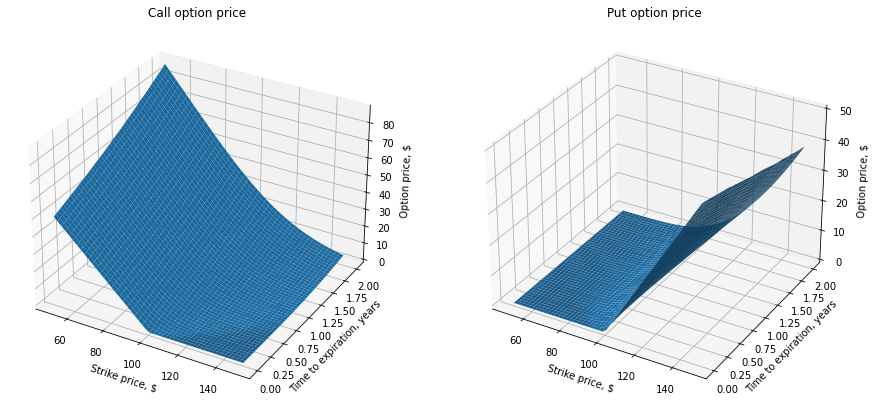

In [12]:
N_SIMULATIONS = 10000
np.random.seed(42)

x, y = np.meshgrid(strikes, times)
call_price = mc_price(calls, market_state, N_SIMULATIONS)
put_price = mc_price(puts, market_state, N_SIMULATIONS)

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(x, y, call_price)
ax1.set_title('Call option price')
ax1.set_xlabel('Strike price, $')
ax1.set_ylabel('Time to expiration, years')
ax1.set_zlabel('Option price, $')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(x, y, put_price)
ax2.set_title('Put option price')
ax2.set_xlabel('Strike price, $')
ax2.set_ylabel('Time to expiration, years')
ax2.set_zlabel('Option price, $')

plt.show()

**3. Error Estimation <span style="color:blue">(20 points)</span>**

It is not sufficient to perform MC simulation, errors should also be estimated.
To obtain price confidence intervals Chebyshev's inequality can be used.
Let $\xi$ be the random variable, and we want to compute it's expectation using MC.
Let $\mu = \mathbb{E} [\xi]$ and $\sigma = \mathrm{var}[\xi]$.
Consider $N$ i.i.d. copies of $\xi$. 
Then:
$$
\mathbb{P} \left( \left\lvert \frac{\xi_1 + \ldots \xi_N}N - \mu \right\rvert \ge \epsilon \right) \le \frac{\sigma^2}{N\epsilon^2}
$$

In practice we usually don't know the variance of $\xi$ and need to estimate it using sample variance.
But in BSM there exists analytical formula for European options payoffs' variances. 
Derive the variances of the call and put opions' final payoff (note the discounting):

$$
\mathrm d = \frac{1}{\sigma \sqrt{T}} \ln{\frac{Ke^{-rT}}{S}}+\frac{1}{2}\sigma\sqrt{T} \\
\mathrm E[C] = S \Phi(-d+\sigma \sqrt{T}) - K e^{-rT} \Phi(-d)\\
\mathrm E[P] = -S \Phi(d - \sigma \sqrt{T}) + K e^{-rT} \Phi(d)\\
\mathrm{E[C^2]} = S^2 e^{\sigma^2 T} \Phi(-d+2\sigma \sqrt{T}) - 2KSe^{-rT} \Phi(-d+\sigma \sqrt{T})+K^2 e^{-2rT}\Phi(-d)\\
\mathrm{E[P^2]} = S^2 e^{\sigma^2 T} \Phi(d-2\sigma \sqrt{T}) - 2KSe^{-rT} \Phi(d-\sigma \sqrt{T})+K^2 e^{-2rT}\Phi(d)\\
\mathrm{var}[C] = E[C^2] - (E[C])^2\\
\mathrm{var}[P] = E[P^2] - (E[P])^2\\
$$

Plot error bars for 10000 MC simulations for 11 strikes from 50 to 150 for 0.95 confidence intervals.

In [13]:
strikes = np.linspace(50, 150, 11)
times = np.linspace(1e-15, 2, 10)

calls = CallStockOption(strike_price=strikes.reshape(1, -1),
                        expiration_time=times.reshape(-1, 1))
puts = PutStockOption(strike_price=strikes.reshape(1, -1),
                      expiration_time=times.reshape(-1, 1))
call_price = mc_price(calls, market_state, N_SIMULATIONS)
put_price = mc_price(puts, market_state, N_SIMULATIONS)

In [14]:
def sigma_(option: StockOption, state: MarketState) -> Union[np.ndarray]:
    
    K = option.strike_price
    S = state.stock_price
    vol = state.volatility
    r = state.interest_rate
    T = option.expiration_time

    d = (1/(vol*(T**0.5)))*np.log((K*np.exp(-r*T))/S) + 0.5*vol*(T**0.5)
    
    if option.is_call:
        e_c_2_1 = (S**2) * np.exp(vol*vol*T) * norm.cdf(-d + 2*vol*(T**0.5) , loc = 0 , scale = 1)
        e_c_2_2 = -2*K*S*np.exp(-r*T)*norm.cdf(-d + vol*(T**0.5) , loc = 0 , scale = 1)
        e_c_2_3 = K*K*np.exp(-2*r*T)*norm.cdf(-d , loc = 0 , scale = 1)
        e_c_1 = S*norm.cdf(-d + vol*(T**0.5) , loc = 0 , scale = 1) - K*np.exp(-r*T)*norm.cdf(-d, loc = 0 , scale = 1)
        return e_c_2_1+e_c_2_2+e_c_2_3 - e_c_1*e_c_1
    else:
        e_p_2_1 = (S**2) * np.exp(vol*vol*T) * norm.cdf(d - 2*vol*(T**0.5) , loc = 0 , scale = 1)
        e_p_2_2 = -2*K*S*np.exp(-r*T)*norm.cdf(d - vol*(T**0.5) , loc = 0 , scale = 1)
        e_p_2_3 = K*K*np.exp(-2*r*T)*norm.cdf(d , loc = 0 , scale = 1)
        e_p_1 = -S*norm.cdf(d - vol*(T**0.5) , loc = 0 , scale = 1) + K*np.exp(-r*T)*norm.cdf(d, loc = 0 , scale = 1)
        return e_p_2_1+e_p_2_2+e_p_2_3 - e_p_1*e_p_1


In [26]:
call_sigma = sigma_(calls, market_state)
put_sigma = sigma_(puts, market_state)
N = 10000
accuracy = 1 - 0.95
def eps(sigm,N, accur):
    return np.sqrt(sigm*sigm/(accur*N))

In [16]:
times

array([1.00000000e-15, 2.22222222e-01, 4.44444444e-01, 6.66666667e-01,
       8.88888889e-01, 1.11111111e+00, 1.33333333e+00, 1.55555556e+00,
       1.77777778e+00, 2.00000000e+00])

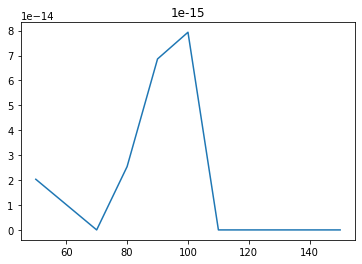

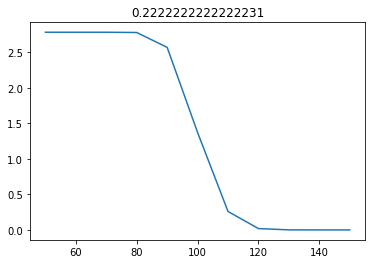

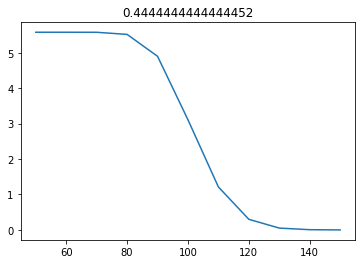

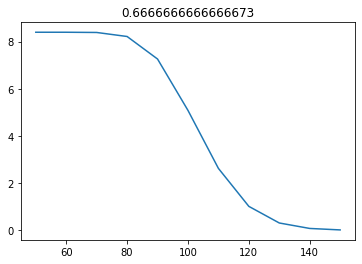

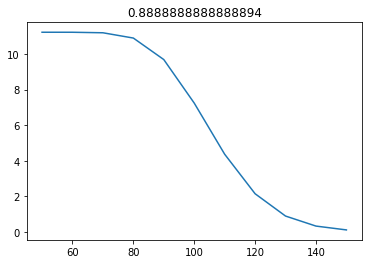

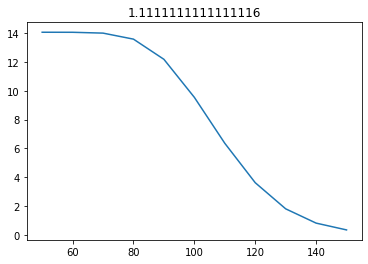

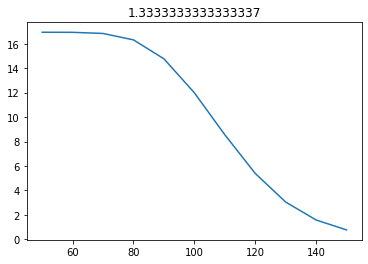

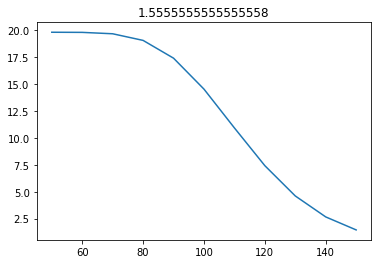

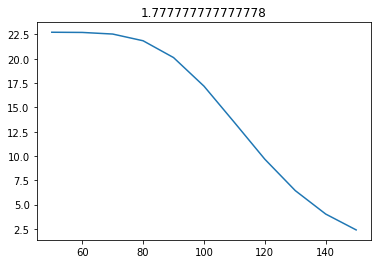

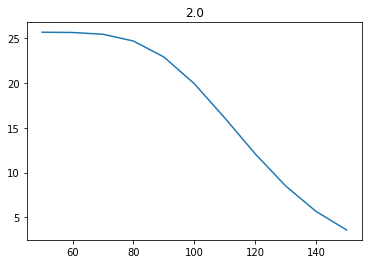

In [17]:
N_SIMULATIONS = 10000
np.random.seed(42)

call_price = mc_price(calls, market_state, N_SIMULATIONS)
put_price = mc_price(puts, market_state, N_SIMULATIONS)

N = 10000
accuracy = 1 - 0.95
def eps(sigm,N, accur):
    return np.sqrt(sigm*sigm/(accur*N))

for i in range(times.size):
    plt.title(times[i])
    tmp_1 = np.reshape(eps(call_sigma, N, accuracy)[i], (-1,1))
    tmp_2 = np.reshape(calls.strike_price,(-1,1))
    plt.plot(tmp_2,tmp_1)
    plt.show()

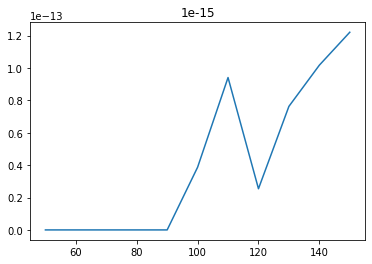

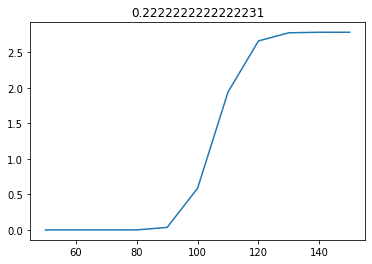

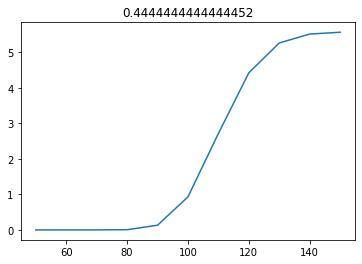

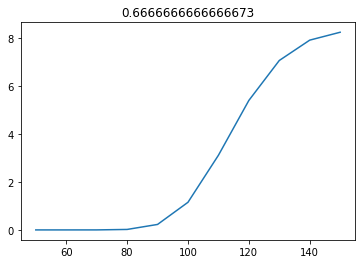

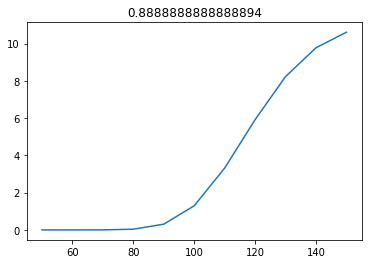

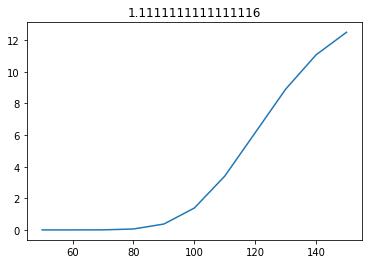

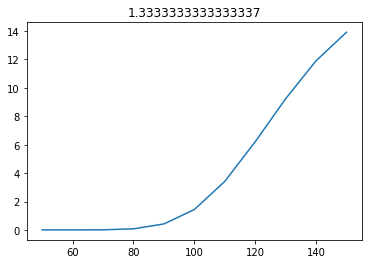

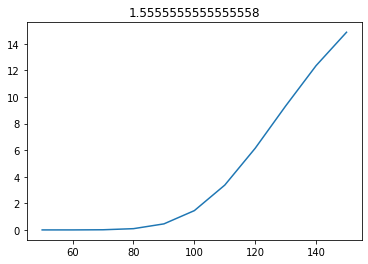

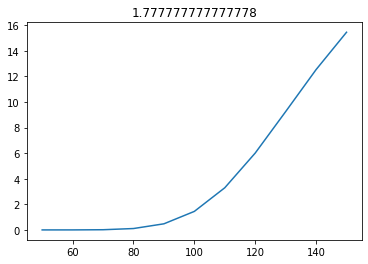

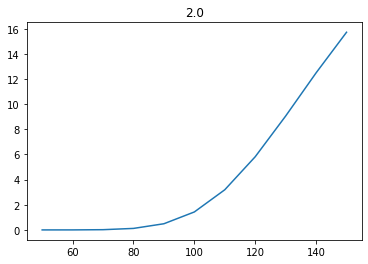

In [18]:
N_SIMULATIONS = 10000
np.random.seed(42)

call_price = mc_price(calls, market_state, N_SIMULATIONS)
put_price = mc_price(puts, market_state, N_SIMULATIONS)

N = 10000
accuracy = 1 - 0.95
def eps(sigm,N, accur):
    return np.sqrt(sigm*sigm/(accur*N))

for i in range(times.size):
    plt.title(times[i])
    tmp_1 = np.reshape(eps(put_sigma, N, accuracy)[i], (-1,1))
    tmp_2 = np.reshape(puts.strike_price,(-1,1))
    plt.plot(tmp_2,tmp_1)
    plt.show()

## Episode 3: The Phantom Implied Volatility (30 points + 30 extra points)

**1. Vanilla Root Finding (30 points)**

Here you are to implement algorithm for computing implied volatility of option.
Volatility in MarketState that is passed to the IV function must be ignored.
Your algorithm should be stable! Comment on the results please.


In [19]:
eps = 1e-1

def calc_iv(option: CallStockOption, state: MarketState, option_price: float):
    """Calculates implied volatility
    
    Args:
        option (CallStockOption): call option parameters, 
            call is used due to the uniqueness of the solution
        state (MarketState): market state, volatility parameter is ignored
        option_price (float): actual option price
    
    Returns:
        float: volatility that produced passed option price
    """
    
    iv = 0.001
    state.volatility = iv
    step = 0.001
    for i in range(1000):
        if(abs(option_price-price(option, state))>eps):
            print(option_price, price(option, state))
            iv += step
            #print(state)
            state.volatility = iv
    return iv

In [20]:
df = pd.read_csv("calls.csv")
df

,strike,price,yahoo_iv,stock_price,time_to_expiration
0,150.0,288.73,0.8307,430.78,0.83
1,160.0,278.77,0.7858,430.78,0.83
2,190.0,242.60,0.5232,430.78,0.83
3,200.0,232.63,0.4950,430.78,0.83
4,250.0,183.87,0.4016,430.78,0.83
...,...,...,...,...,...
86,550.0,1.34,0.1594,430.78,0.83
87,560.0,1.02,0.1601,430.78,0.83
88,565.0,0.89,0.1605,430.78,0.83
89,600.0,0.42,0.1681,430.78,0.83


In [21]:
PLACEHOLDER_VOL = 0.2

In [22]:
market_state = MarketState(stock_price=df.at[0, "stock_price"],
                           volatility=PLACEHOLDER_VOL,
                           interest_rate=0.0)

In [23]:
for idx, row in df.iterrows():
    option = CallStockOption(strike_price=row["strike"],
                             expiration_time=row["time_to_expiration"])
    df.at[idx, "iv"] = calc_iv(option, market_state, row["price"])

288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73 280.78
288.73

288.73 280.8682443611947
288.73 280.87036478437943
288.73 280.8725229188792
288.73 280.87471916025993
288.73 280.8769539040658
288.73 280.8792275457753
288.73 280.88154048075717
288.73 280.88389310422775
288.73 280.8862858112071
288.73 280.8887189964769
288.73 280.89119305453823
288.73 280.8937083795695
288.73 280.8962653653849
288.73 280.8988644053936
288.73 280.90150589255904
288.73 280.9041902193585
288.73 280.9069177777433
288.73 280.9096889590995
288.73 280.91250415420905
288.73 280.91536375321084
288.73 280.9182681455629
288.73 280.9212177200045
288.73 280.92421286451923
288.73 280.92725396629794
288.73 280.9303414117026
288.73 280.9334755862301
288.73 280.9366568744775
288.73 280.9398856601062
288.73 280.9431623258083
288.73 280.94648725327215
288.73 280.94986082314864
288.73 280.9532834150185
288.73 280.9567554073596
288.73 280.9602771775146
288.73 280.96384910165955
288.73 280.9674715547727
288.73 280.97114491060347
288.73 280.97486954164293
288.73 280.97864581909306
288.73 28

278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77 270.78
278.77

278.77 271.70734949257695
278.77 271.71878976068245
278.77 271.7303189070618
278.77 271.7419371074541
278.77 271.7536445348939
278.77 271.7654413597208
278.77 271.77732774958747
278.77 271.78930386946837
278.77 271.80136988166936
278.77 271.8135259458363
278.77 271.8257722189651
278.77 271.83810885541004
278.77 271.85053600689497
278.77 271.8630538225219
278.77 271.8756624487818
278.77 271.88836202956406
278.77 271.9011527061672
278.77 271.9140346173093
278.77 271.92700789913823
278.77 271.94007268524246
278.77 271.9532291066621
278.77 271.96647729189925
278.77 271.97981736692975
278.77 271.9932494552138
278.77 272.0067736777073
278.77 272.0203901528734
278.77 272.03409899669396
278.77 272.047900322681
278.77 272.0617942418884
278.77 272.0757808629238
278.77 272.08986029196024
278.77 272.1040326327483
278.77 272.1182979866282
278.77 272.1326564525415
278.77 272.147108127044
278.77 272.1616531043173
278.77 272.1762914761814
278.77 272.19102333210753
278.77 272.20584875922987
278.77 272.

242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.77999999999997
242.6 240.78
242.6 240.78

242.6 242.32976855715253
242.6 242.34807512594057
242.6 242.36650903601694
242.6 242.3850703668189
242.6 242.4037591938331
242.6 242.42257558862676
242.6 242.44151961887832
242.6 242.46059134840817
242.6 242.47979083720972
242.6 242.4991181414801
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997
232.63 230.77999999999997

232.63 231.39687857891528
232.63 231.40775218476506
232.63 231.41874979774832
232.63 231.42987187218972
232.63 231.4411188556595
232.63 231.4524911889839
232.63 231.4639893062568
232.63 231.47561363485212
232.63 231.48736459543812
232.63 231.49924260199177
232.63 231.51124806181483
232.63 231.52338137555097
232.63 231.53564293720314
232.63 231.5480331341529
232.63 231.5605523471798
232.63 231.57320095048223
232.63 231.58597931169905
232.63 231.59888779193165
232.63 231.6119267457676
232.63 231.62509652130436
232.63 231.63839746017422
232.63 231.65182989757002
232.63 231.66539416227104
232.63 231.67909057667052
232.63 231.69291945680308
232.63 231.70688111237317
232.63 231.72097584678409
232.63 231.7352039571677
232.63 231.74956573441474
232.63 231.7640614632053
232.63 231.77869142204102
232.63 231.79345588327612
232.63 231.80835511315036
232.63 231.82338937182206
232.63 231.83855891340158
232.63 231.85386398598516
232.63 231.869304831689
232.63 231.8848816866847
232.63 231.900594781234

140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.77999999999997
140.02 130.7

115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999997
115.22 105.77999999999992
115.22 105.7

110.92 101.88848079390704
110.92 101.9214561591844
110.92 101.95497033505364
110.92 101.98902268894324
110.92 102.02361249394954
110.92 102.05873893193046
110.92 102.09440109654707
110.92 102.13059799625245
110.92 102.16732855722631
110.92 102.20459162625514
110.92 102.24238597355651
110.92 102.28071029554735
110.92 102.3195632175553
110.92 102.35894329647385
110.92 102.39884902335939
110.92 102.43927882597222
110.92 102.48023107125965
110.92 102.5217040677822
110.92 102.56369606808346
110.92 102.60620527100315
110.92 102.64922982393375
110.92 102.69276782502209
110.92 102.73681732531531
110.92 102.7813763308526
110.92 102.82644280470197
110.92 102.87201466894504
110.92 102.91808980660778
110.92 102.96466606354011
110.92 103.01174125024397
110.92 103.05931314365068
110.92 103.1073794888498
110.92 103.15593800076681
110.92 103.20498636579595
110.92 103.25452224338295
110.92 103.30454326756364
110.92 103.35504704845607
110.92 103.40603117370853
110.92 103.45749320990382
110.92 103.509430

102.6 96.47315376685134
102.6 96.54918920276214
102.6 96.62560238708306
102.6 96.70239037625305
102.6 96.7795502452272
102.6 96.85707908761259
102.6 96.9349740157914
102.6 97.01323216103236
102.6 97.09185067359073
102.6 97.17082672279668
102.6 97.25015749713396
102.6 97.32984020430746
102.6 97.409872071302
102.6 97.49025034443042
102.6 97.5709722893746
102.6 97.65203519121587
102.6 97.73343635445883
102.6 97.81517310304628
102.6 97.89724278036721
102.6 97.97964274925704
102.6 98.06237039199192
102.6 98.14542311027503
102.6 98.22879832521801
102.6 98.31249347731546
102.6 98.39650602641422
102.6 98.48083345167657
102.6 98.5654732515394
102.6 98.65042294366651
102.6 98.73568006489853
102.6 98.82124217119605
102.6 98.90710683758022
102.6 98.99327165806835
102.6 99.07973424560555
102.6 99.16649223199363
102.6 99.25354326781547
102.6 99.34088502235642
102.6 99.42851518352319
102.6 99.51643145775859
102.6 99.60463156995462
102.6 99.69311326336242
102.6 99.7818742994993
102.6 99.87091245805425

94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.77999999999992
94.26 80.77999999999997
94.26 80.77999999999997
94.26 80.78000000000009
94.26 80.78000000000077
94.26 80.78000000000395
94.26 80.78000000001742
94.26 80.78000000006716
94.26 80.78000000023292
94.26 80.78000000073376
94.26 80.78000000212211
94.26 80.78000000568238
94.26 80.78000001419417
94.26 80.78000003329453
94.26 80.7800000

90.45 79.242555302619
90.45 79.31124696409944
90.45 79.38049706985487
90.45 79.4503006294766
90.45 79.52065267406658
90.45 79.5915482575005
90.45 79.6629824576122
90.45 79.73495037730521
90.45 79.80744714559245
90.45 79.88046791856891
90.45 79.95400788031878
90.45 80.02806224376104
90.45 80.10262625143525
90.45 80.17769517623123
90.45 80.25326432206379
90.45 80.32932902449721
90.45 80.40588465131805
90.45 80.4829266030635
90.45 80.56045031350249
90.45 80.63845125007583
90.45 80.71692491429383
90.45 80.79586684209642
90.45 80.8752726041755
90.45 80.95513780626163
90.45 81.0354580893781
90.45 81.11622913006198
90.45 81.19744664055588
90.45 81.27910636896974
90.45 81.36120409941566
90.45 81.44373565211697
90.45 81.52669688349192
90.45 81.61008368621441
90.45 81.693891989252
90.45 81.77811775788331
90.45 81.86275699369486
90.45 81.94780573455944
90.45 82.03326005459695
90.45 82.11911606411667
90.45 82.20536990954616
90.45 82.2920177733422
90.45 82.37905587389014
90.45 82.46648046538769
90.

82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.77999999999997
82.34 65.78000000000003
82.34 65.78000000000014
82.34 65.78000000000168
82.34 65.78000000001123
82.34 65.78000000006159
82.34 65.7800000002847
82.34 65.78000000113894
82.34 65.7800000040163
82.34 65.78000001267617
82.34 65.78000003627972
82.34 65.78000009521372
82.34 65.78000023134882
82.34 65.78000052477142
82.34 65.78000111926934
82.34 65.78000225883363
82.34 65.78000433711384
82.34 65.78000796112843
82.34 65.78001402963702
82.34 65.780023825

78.42 66.64500929214421
78.42 66.73747896605806
78.42 66.83041116804202
78.42 66.92380032507816
78.42 67.01764093504482
78.42 67.11192756611075
78.42 67.20665485610976
78.42 67.30181751190037
78.42 67.39741030871039
78.42 67.49342808946915
78.42 67.58986576412786
78.42 67.68671830896966
78.42 67.78398076591196
78.42 67.88164824179995
78.42 67.97971590769453
78.42 68.0781789981549
78.42 68.17703281051672
78.42 68.27627270416662
78.42 68.37589409981456
78.42 68.47589247876431
78.42 68.57626338218358
78.42 68.67700241037261
78.42 68.77810522203504
78.42 68.87956753354808
78.42 68.98138511823561
78.42 69.08355380564302
78.42 69.1860694808143
78.42 69.28892808357358
78.42 69.39212560780811
78.42 69.49565810075745
78.42 69.5995216623055
78.42 69.70371244427764
78.42 69.80822664974306
78.42 69.91306053232165
78.42 70.01821039549725
78.42 70.12367259193587
78.42 70.2294435228103
78.42 70.33551963713063
78.42 70.44189743108114
78.42 70.54857344736342
78.42 70.6555442745468
78.42 70.762806546424

70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.77999999999997
70.76 50.78000000000003
70.76 50.7800000000002
70.76 50.780000000002985
70.76 50.78000000003124
70.76 50.78000000024127
70.76 50.78000000144965
70.76 50.78000000706089
70.76 50.780000028804466
70.76 50.78000010104324
70.76 50.78000031144495
70.76 50.78000085866438
70.76 50.78000214918768
70.76 50.78000494455887
70.76 50.78001056642654
70.76 50.78002116063084
70.76 50.78004001403349
70.76 50.780071910443496
70.76 50.78012350615262
70.76 50.78020370218036
70.76 50.780323989672695
70.76 50.78049874681841
70.76 50.780745469570206
70.76 50.781084923642595
70.76 50.78154121093746
70.76 50.78

69.7 61.80757844537271
69.7 61.93530106263381
69.7 62.06317318371967
69.7 62.19119295799018
69.7 62.319358562058596
69.7 62.44766819930197
69.7 62.57612009938248
69.7 62.704712517777836
69.7 62.83344373532171
69.7 62.962312057753365
69.7 63.09131581527623
69.7 63.22045336212591
69.7 63.34972307614615
69.7 63.47912335837415
69.7 63.60865263263349
69.7 63.73830934513606
69.7 63.86809196409115
69.7 63.997998979323086
69.7 64.1280289018957
69.7 64.25818026374509
69.7 64.38845161731919
69.7 64.51884153522477
69.7 64.64934860988097
69.7 64.77997145318054
69.7 64.91070869615638
69.7 65.04155898865656
69.7 65.1725209990239
69.7 65.30359341378272
69.7 65.43477493733175
69.7 65.56606429164273
69.7 65.69746021596512
69.7 65.82896146653636
69.7 65.96056681629776
69.7 66.09227505461607
69.7 66.22408498701043
69.7 66.35599543488419
69.7 66.48800523526225
69.7 66.62011324053341
69.7 66.75231831819752
69.7 66.8846193506175
69.7 67.01701523477601
69.7 67.14950488203704
69.7 67.28208721791185
69.7 67.41

60.03 35.77999999999997
60.03 35.77999999999997
60.03 35.77999999999997
60.03 35.77999999999997
60.03 35.77999999999997
60.03 35.77999999999997
60.03 35.77999999999997
60.03 35.77999999999997
60.03 35.77999999999997
60.03 35.77999999999997
60.03 35.77999999999997
60.03 35.77999999999997
60.03 35.780000000000086
60.03 35.78000000000395
60.03 35.78000000009422
60.03 35.78000000129816
60.03 35.78000001163542
60.03 35.78000007437248
60.03 35.78000036295225
60.03 35.78000142411378
60.03 35.780004674876636
60.03 35.78001324327795
60.03 35.78003317819855
60.03 35.780074959691945
60.03 35.780155153588794
60.03 35.78029800381222
60.03 35.78053675539417
60.03 35.780914543992765
60.03 35.78148475582515
60.03 35.78231083548883
60.03 35.78346558279537
60.03 35.78503002508671
60.03 35.78709197644821
60.03 35.789744402041435
60.03 35.793083698911005
60.03 35.797207989006495
60.03 35.80221550024072
60.03 35.80820309054491
60.03 35.81526495039719
60.03 35.82349150249297
60.03 35.832968503664574
60.03 3

56.29 51.48479807174195
56.29 51.62541587381017
56.29 51.76610776292611
56.29 51.90687268646164
56.29 52.04770960867711
56.29 52.188617510377554
56.29 52.329595388579094
56.29 52.47064225618186
56.29 52.61175714165108
56.29 52.75293908870631
56.29 52.89418715601707
56.29 53.035500416905876
56.29 53.17687795905891
56.29 53.31831888424264
56.29 53.459822308027356
56.29 53.60138735951699
56.29 53.74301318108556
56.29 53.88469892811895
56.29 54.02644376876344
56.29 54.1682468836795
56.29 54.31010746580111
56.29 54.452024720100894
56.29 54.59399786336036
56.29 54.736026123945464
56.29 54.878108741586914
56.29 55.02024496716567
56.29 55.16243406250322
56.29 55.304675300156475
56.29 55.446967963217276
56.29 55.58931134511576
56.29 55.731704749429355
56.29 55.874147489694394
56.29 56.01663888922329
56.29 56.15917828092435
52.84 25.779999999999973
52.84 25.779999999999973
52.84 25.779999999999973
52.84 25.779999999999973
52.84 25.779999999999973
52.84 25.779999999999973
52.84 25.779999999999973

49.61 39.09789533256327
49.61 39.24339843268598
49.61 39.388968349516574
49.61 39.53460389774585
49.61 39.68030391622321
49.61 39.826067267332775
49.61 39.971892836388946
49.61 40.11777953105067
49.61 40.26372628075262
49.61 40.40973203615454
49.61 40.55579576860592
49.61 40.701916469628
49.61 40.84809315040977
49.61 40.994324841319894
49.61 41.140610591432534
49.61 41.28694946806715
49.61 41.43334055634173
49.61 41.579782958738974
49.61 41.726275794684966
49.61 41.87281820014019
49.61 42.01940932720191
49.61 42.166048343718245
49.61 42.31273443291258
49.61 42.45946679301957
49.61 42.60624463693071
49.61 42.75306719184954
49.61 42.899933698957454
49.61 43.04684341308746
49.61 43.19379560240867
49.61 43.340789548117726
49.61 43.487824544139755
49.61 43.634899896837254
49.61 43.78201492472647
49.61 43.92916895820227
49.61 44.076361339269596
49.61 44.223591421282634
49.61 44.37085856869072
49.61 44.51816215679102
49.61 44.66550157148794
49.61 44.81287620905843
49.61 44.96028547592448
49.6

43.04 40.38046030097095
43.04 40.53307834741307
43.04 40.68569946791797
43.04 40.838323496253736
43.04 40.99095026853021
43.04 41.14357962314915
43.04 41.29621140075457
43.04 41.44884544418531
43.04 41.60148159842825
43.04 41.75411971057267
43.04 41.9067596297663
43.04 42.05940120717179
43.04 42.2120442959249
43.04 42.36468875109327
43.04 42.51733442963635
43.04 42.66998119036671
43.04 42.82262889391163
39.84 5.779999999999973
39.84 5.779999999999973
39.84 5.780000084989922
39.84 5.7800392846104955
39.84 5.780841038314236
39.84 5.7851228038546765
39.84 5.79678298689322
39.84 5.81887353067691
39.84 5.852839642019887
39.84 5.898814522243356
39.84 5.956150031124196
39.84 6.0238330548503995
39.84 6.100740770640698
39.84 6.185776483391237
39.84 6.277932510415383
39.84 6.376312734548662
39.84 6.48013450921718
39.84 6.5887209375915745
39.84 6.701489394737166
39.84 6.817939267091049
39.84 6.937640314466194
39.84 7.06022223431529
39.84 7.185365589087041
39.84 7.31279405657682
39.84 7.4422678767

37.4 30.08113871674783
37.4 30.23676891191772
37.4 30.39239351987112
37.4 30.548012500878883
37.4 30.70362581537634
37.4 30.859233423958898
37.4 31.014835287378048
37.4 31.170431366537485
37.4 31.326021622489264
37.4 31.48160601643039
37.4 31.637184509698784
37.4 31.792757063770324
37.4 31.948323640255268
37.4 32.10388420089484
37.4 32.25943870755867
37.4 32.41498712224097
37.4 32.57052940705819
37.4 32.72606552424591
37.4 32.881595436155976
37.4 33.037119105253936
37.4 33.19263649411633
37.4 33.34814756542829
37.4 33.503652281980806
37.4 33.65915060666856
37.4 33.814642502487374
37.4 33.97012793253222
37.4 34.12560685999469
37.4 34.28107924816118
37.4 34.43654506041054
37.4 34.592004260212235
37.4 34.74745681112415
37.4 34.90290267679097
37.4 35.05834182094219
37.4 35.213774207390145
37.4 35.369199800028525
37.4 35.52461856283054
37.4 35.68003045984722
37.4 35.83543545520584
37.4 35.99083351310827
37.4 36.146224597829644
37.4 36.30160867371657
37.4 36.456985705186014
37.4 36.612355656

35.47 0.00010344337778017687
35.47 0.020434481475930966
35.47 0.09190481119634342
35.47 0.1970797680511822
35.47 0.320363151157423
35.47 0.4539091914084281
35.47 0.593713040939889
35.47 0.737579810697099
35.47 0.8842217192568
35.47 1.0328383717349539
35.47 1.1829079683415387
35.47 1.3340765644841213
35.47 1.4860959492175425
35.47 1.638787077270166
35.47 1.7920176339924865
35.47 1.945687770607293
35.47 2.09972074833658
35.47 2.25405663303286
35.47 2.408647942593859
35.47 2.5634565777600926
35.47 2.7184516163583226
35.47 2.8736077007889094
35.47 3.0289038408937756
35.47 3.1843225126903576
35.47 3.339848971152321
35.47 3.495470720058904
35.47 3.6511770986161025
35.47 3.806958955935613
35.47 3.962808392353651
35.47 4.118718552121919
35.47 4.274683455959803
35.47 4.430697864810554
35.47 4.586757168226683
35.47 4.74285729234623
35.47 4.898994623564391
35.47 5.055165944865905
35.47 5.2113683824353245
35.47 5.367599360661359
35.47 5.52385656403564
35.47 5.680137904744981
35.47 5.83644149498877

34.92 28.690591380890055
34.92 28.846904408077478
34.92 29.003211954436836
34.92 29.159513976627437
34.92 29.31581043154236
34.92 29.472101276302027
34.92 29.628386468248976
34.92 29.784665964942036
34.92 29.940939724151207
34.92 30.097207703852206
34.92 30.253469862221806
34.92 30.409726157632605
34.92 30.565976548648507
34.92 30.722220994020063
34.92 30.87845945268012
34.92 31.034691883739157
34.92 31.190918246481715
34.92 31.347138500361552
34.92 31.50335260499844
34.92 31.659560520173613
34.92 31.8157622058267
34.92 31.971957622051605
34.92 32.128146729093146
34.92 32.28432948734377
34.92 32.440505857340014
34.92 32.59667579975945
34.92 32.7528392754173
34.92 32.90899624526372
34.92 33.0651466703805
34.92 33.22129051197845
34.92 33.37742773139436
34.92 33.53355829008842
34.92 33.68968214964147
34.92 33.8457992717525
34.92 34.001909618236084
34.92 34.15801315101996
34.92 34.31410983214249
34.92 34.47019962375066
34.92 34.6262824880975
34.92 34.78235838754006
34.43 6.97848710928335e-

33.87 25.602406176642376
33.87 25.758944156626313
33.87 25.915479619687233
33.87 26.07201247921401
33.87 26.228542649803728
33.87 26.385070047228368
33.87 26.541594588402575
33.87 26.698116191352938
33.87 26.854634775187662
33.87 27.011150260067552
33.87 27.1676625671781
33.87 27.324171618701854
33.87 27.480677337792514
33.87 27.637179648548937
33.87 27.793678475991015
33.87 27.950173746034977
33.87 28.106665385470848
33.87 28.26315332193974
33.87 28.419637483911856
33.87 28.576117800665685
33.87 28.732594202267478
33.87 28.889066619551272
33.87 29.04553498409973
33.87 29.201999228225475
33.87 29.358459284953
33.87 29.514915088001146
33.87 29.671366571765816
33.87 29.82781367130383
33.87 29.984256322316554
33.87 30.140694461134416
33.87 30.29712802470192
33.87 30.45355695056267
33.87 30.609981176845366
33.87 30.766400642249835
33.87 30.922815286033455
33.87 31.079225047998392
33.87 31.23562986847844
33.87 31.392029688327256
33.87 31.548424448905706
33.87 31.704814092070762
33.87 31.861

32.03 3.1217622619947658e-21
32.03 1.1067981174814247e-10
32.03 8.13500355033997e-07
32.03 6.336678109738342e-05
32.03 0.0007852368842575785
32.03 0.003974086629467299
32.03 0.012269860110491138
32.03 0.028110125592382573
32.03 0.053110553841523966
32.03 0.08800288560878755
32.03 0.13283723941660952
32.03 0.18722590852668475
32.03 0.2505401746283482
32.03 0.32204509840565976
32.03 0.40098313710192457
32.03 0.48662188763236713
32.03 0.5782787136993051
32.03 0.6753312889048857
32.03 0.7772199675685698
32.03 0.8834456781182922
32.03 0.9935655731820532
32.03 1.1071877470823779
32.03 1.2239657628834806
32.03 1.3435933880627573
32.03 1.4657997347886038
32.03 1.5903448832952876
32.03 1.7170160010512916
32.03 1.845623935465028
32.03 1.9760002410406372
32.03 2.107994595487966
32.03 2.24147255867517
32.03 2.37631363074631
32.03 2.5124095695886837
32.03 2.6496629322102763
32.03 2.7879858089588367
32.03 2.927298723622073
32.03 3.0675296761641846
32.03 3.2086133081489834
32.03 3.3504901737668717
32

31.39 23.089453017565262
31.39 23.245877891635985
31.39 23.4023104163754
31.39 23.55875033151426
31.39 23.715197381962128
31.39 23.87165131766153
31.39 24.02811189344692
31.39 24.184578868908233
31.39 24.341052008259112
31.39 24.497531080209512
31.39 24.654015857842467
31.39 24.810506118494743
31.39 24.96700164364148
31.39 25.123502218784807
31.39 25.280007633345633
31.39 25.43651768055912
31.39 25.593032157373415
31.39 25.749550864351818
31.39 25.90607360557766
31.39 26.06260018856227
31.39 26.219130424156276
31.39 26.375664126462908
31.39 26.532201112754393
31.39 26.68874120339123
31.39 26.845284221742986
31.39 27.00182999411254
31.39 27.158378349662172
31.39 27.314929120341617
31.39 27.471482140818722
31.39 27.6280372484118
31.39 27.784594283024518
31.39 27.941153087082057
31.39 28.097713505469414
31.39 28.25427538547197
31.39 28.410838576716827
31.39 28.56740293111676
31.39 28.72396830281525
31.39 28.88053454813334
31.39 29.03710152551784
31.39 29.19366909549106
31.39 29.3502371206

29.72 2.1461783653267144e-177
29.72 9.00105939686024e-47
29.72 3.1466350569698287e-22
29.72 1.86364131488704e-13
29.72 2.7556963204965256e-09
29.72 5.989119723316194e-07
29.72 1.7257138564229224e-05
29.72 0.00016640825946087623
29.72 0.0008391826590934959
29.72 0.0028067420128659037
29.72 0.007135894187523473
29.72 0.014986315969538921
29.72 0.027418174334929546
29.72 0.04527550425242843
29.72 0.06914639854124083
29.72 0.09937481768286105
29.72 0.13609813075759192
29.72 0.1792924670203888
29.72 0.22881597909680096
29.72 0.28444569392960517
29.72 0.3459068379967576
29.72 0.41289510223133874
29.72 0.4850929340813792
29.72 0.5621810686899593
29.72 0.6438464097837553
29.72 0.7297871889362568
29.72 0.8197161402324724
29.72 0.9133622561109718
29.72 1.010471548835227
29.72 1.1108071306244227
29.72 1.2141488401386908
29.72 1.320292578922377
29.72 1.4290494739398696
29.72 1.5402449475554647
29.72 1.6537177510391672
29.72 1.769318999464403
29.72 1.88691123283202
29.72 2.0063675190082932
29.72 2.

29.15 24.726198182972553
29.15 24.882363582002995
29.15 25.038543206293326
29.15 25.19473670961608
29.15 25.3509437520826
29.15 25.507163999984527
29.15 25.663397125639563
29.15 25.819642807241877
29.15 25.975900728717505
29.15 26.132170579583118
29.15 26.288452054809795
29.15 26.444744854690015
29.15 26.601048684709127
29.15 26.75736325542016
29.15 26.913688282322255
29.15 27.070023485742723
29.15 27.22636859072253
29.15 27.382723326904596
29.15 27.539087428425802
29.15 27.69546063381162
29.15 27.85184268587389
29.15 28.008233331611336
29.15 28.164632322112965
29.15 28.32103941246399
29.15 28.47745436165448
29.15 28.63387693249021
29.15 28.790306891506503
29.15 28.9467440088836
28.62 1.3183627098740501e-243
28.62 1.987853586709418e-63
28.62 1.0489151415522227e-29
28.62 1.0180824514474601e-17
28.62 4.6494397868198054e-12
28.62 6.538910896541779e-09
28.62 5.829610740936287e-07
28.62 1.1737113422805381e-05
28.62 9.831100260882658e-05
28.62 0.0004737743454576726
28.62 0.001581401478842559

28.12 21.907950632451758
28.12 22.06345432779554
28.12 22.218986102328955
28.12 22.374545370103846
28.12 22.53013155707464
28.12 22.685744100780994
28.12 22.841382450040953
28.12 22.997046064653688
28.12 23.152734415111155
28.12 23.308446982319452
28.12 23.464183257328216
28.12 23.619942741068655
28.12 23.775724944099608
28.12 23.931529386361547
28.12 24.08735559693764
28.12 24.243203113822517
28.12 24.399071483697526
28.12 24.554960261713404
28.12 24.71086901127873
28.12 24.866797303855066
28.12 25.022744718758133
28.12 25.17871084296462
28.12 25.334695270924897
28.12 25.490697604381182
28.12 25.6467174521907
28.12 25.802754430154124
28.12 25.958808160849316
28.12 26.114878273469003
28.12 26.270964403663783
28.12 26.42706619338935
28.12 26.583183290758
28.12 26.739315349894213
28.12 26.895462030794533
28.12 27.051622999191068
28.12 27.20779792641892
28.12 27.36398648928747
28.12 27.520188369954525
28.12 27.676403255804843
28.12 27.832630839331017
28.12 27.988870818018512
27.61 0.0
27.

26.59 0.0
26.59 2.2538752122455733e-104
26.59 5.0321963680192203e-48
26.59 4.076252103101995e-28
26.59 8.681309640585245e-19
26.59 1.2068899441068788e-13
26.59 1.7244617853769698e-10
26.59 2.1102511198397986e-08
26.59 6.113620091249589e-07
26.59 7.180636371428937e-06
26.59 4.6466210137350444e-05
26.59 0.00019944089701595669
26.59 0.0006387856556425431
26.59 0.001650284049816042
26.59 0.003626739933620615
26.59 0.007038248960044902
26.59 0.012391017884649802
26.59 0.02018669291434172
26.59 0.03088967589912084
26.59 0.04490518317665959
26.59 0.06256758779617222
26.59 0.08413702124854794
26.59 0.1098018090383075
26.59 0.13968453993764385
26.59 0.17385003898629847
26.59 0.21231401241755066
26.59 0.2550515604246044
26.59 0.3020050817175566
26.59 0.35309132653242514
26.59 0.40820750942549466
26.59 0.46723648937759066
26.59 0.5300510797403817
26.59 0.5965175779870862
26.59 0.6664986150814798
26.59 0.7398554235400425
26.59 0.8164496166198703
26.59 0.8961445615541237
26.59 0.9788064192537789
26

25.91 21.936891743118395
25.91 22.09162354906786
25.91 22.246395902905874
25.91 22.401208053959664
25.91 22.556059266088255
25.91 22.710948817318524
25.91 22.865875999492317
25.91 23.020840117923854
25.91 23.175840491067618
25.91 23.33087645019495
25.91 23.485947339081775
25.91 23.6410525137035
25.91 23.796191341940272
25.91 23.95136320329007
25.91 24.106567488589633
25.91 24.261803599744212
25.91 24.41707094946443
25.91 24.57236896101071
25.91 24.727697067944746
25.91 24.883054713888328
25.91 25.038441352288544
25.91 25.1938564461895
25.91 25.34929946801057
25.91 25.504769899330654
25.91 25.660267230678187
25.44 0.0
25.44 1.3323753605486158e-128
25.44 7.641374786024193e-59
25.44 3.0600404974045908e-34
25.44 9.713979454876094e-23
25.44 2.0498426510381375e-16
25.44 1.5121156136134765e-12
25.44 5.376976426895184e-10
25.44 3.240874865699758e-08
25.44 6.435759725254659e-07
25.44 6.1485437888339316e-06
25.44 3.5525907607513244e-05
25.44 0.00014352255900351718
25.44 0.0004461316924728731
25.

24.46 0.0
24.46 2.719166741290398e-155
24.46 9.44952864070784e-71
24.46 5.6532895492606e-41
24.46 4.461224234591948e-27
24.46 1.885945363742834e-19
24.46 8.487775236738874e-15
24.46 9.771519184558122e-12
24.46 1.3192240860493942e-09
24.46 4.6684675316692394e-08
24.46 6.844869893643437e-07
24.46 5.48222385713705e-06
24.46 2.8576370332298456e-05
24.46 0.00010880455644234066
24.46 0.00032737291186529793
24.46 0.0008225354446676214
24.46 0.00179558974456967
24.46 0.003506330177660111
24.46 0.006259862823628115
24.46 0.010388596949754803
24.46 0.016233276058065904
24.46 0.02412590617600463
24.46 0.034376170031337416
24.46 0.04726184343506823
24.46 0.06302301164565627
24.46 0.08185949913112722
24.46 0.10393078820081136
24.46 0.12935771670163732
24.46 0.158225338205634
24.46 0.19058645021373977
24.46 0.2264654178731682
24.46 0.26586202814683446
24.46 0.30875519699819876
24.46 0.35510641975926305
24.46 0.4048629047036556
24.46 0.4579603650912105
24.46 0.5143254687857635
24.46 0.573877959812911

23.33 0.0
23.33 2.060044914583515e-184
23.33 9.808775559107736e-84
23.33 2.6106219451257663e-48
23.33 8.484243488574837e-32
23.33 9.449708484314291e-23
23.33 3.059991855111511e-17
23.33 1.269125487464015e-13
23.33 4.1287797938006745e-11
23.33 2.742941713405464e-09
23.33 6.413539774012333e-08
23.33 7.330471810648763e-07
23.33 5.042350198293348e-06
23.33 2.3937810323056835e-05
23.33 8.60981332469965e-05
23.33 0.00025046361843894527
23.33 0.0006176218986366222
23.33 0.001336251532997157
23.33 0.002602741581859247
23.33 0.004654396561485918
23.33 0.007758167445180986
23.33 0.012197333895871632
23.33 0.01825827274567482
23.33 0.026218797803883476
23.33 0.03633886731809355
23.33 0.048853897762226595
23.33 0.06397054733069929
23.33 0.08186462406775163
23.33 0.10268069043526751
23.33 0.12653293442844848
23.33 0.15350692117320897
23.33 0.18366190287752104
23.33 0.217033433048055
23.33 0.25363609408965715
23.33 0.2934662016255096
23.33 0.3365043929052014
23.33 0.3827180409244164
23.33 0.43206346

22.95 17.51492326225255
22.95 17.666106250057254
22.95 17.817385473160982
22.95 17.96875923559321
22.95 18.12022587693386
22.95 18.27178377137949
22.95 18.423431326837886
22.95 18.575166984051236
22.95 18.726989215745846
22.95 18.87889652580779
22.95 19.03088744848381
22.95 19.182960547606285
22.95 19.335114415841645
22.95 19.48734767396118
22.95 19.63965897013378
22.95 19.792046979239757
22.95 19.944510402204514
22.95 20.097047965352544
22.95 20.24965841977982
22.95 20.40234054074466
22.95 20.555093127076645
22.95 20.707915000601815
22.95 20.860805005585377
22.95 21.01376200818987
22.95 21.166784895948837
22.95 21.31987257725544
22.95 21.47302398086586
22.95 21.626238055416252
22.95 21.779513768953677
22.95 21.932850108479812
22.95 22.08624607950736
22.95 22.239700705629247
22.95 22.393213028098927
22.95 22.54678210542278
22.95 22.700407012963637
22.48 0.0
22.48 6.227838168177112e-216
22.48 8.811990248866175e-98
22.48 3.062261590652304e-56
22.48 6.744923355503628e-37
22.48 2.593907471

21.44 0.0
21.44 8.071669965502781e-250
21.44 7.065036039804901e-113
21.44 9.274875461923153e-65
21.44 2.2636181181681992e-42
21.44 3.925227852285745e-30
21.44 1.0704065501562212e-22
21.44 7.897986517243353e-18
21.44 1.8512691964277636e-14
21.44 5.056094706383615e-12
21.44 3.368305809918136e-10
21.44 8.545276139311003e-09
21.44 1.0942549596733281e-07
21.44 8.513267177435264e-07
21.44 4.5648176561516405e-06
21.44 1.84258548477376e-05
21.44 5.96487366575256e-05
21.44 0.0001622157199536317
21.44 0.0003836646673472388
21.44 0.0008102309834720489
21.44 0.0015591163964071564
21.44 0.0027774770537714044
21.44 0.004638485136462367
21.44 0.007335294433997719
21.44 0.011073897325762472
21.44 0.01606577856167357
21.44 0.0225210609918296
21.44 0.03064259251107515
21.44 0.0406212002030113
21.44 0.05263216393313108
21.44 0.06683284289625213
21.44 0.08336131854983542
21.44 0.10233588496745405
21.44 0.12385521150370415
21.44 0.1479990129752604
21.44 0.17482908184065948
21.44 0.20439055985394283
21.44 0

20.94 19.05904980035271
20.94 19.209940707544263
20.94 19.360925821560755
20.94 19.512003633500797
20.94 19.663172662826355
20.94 19.814431456693
20.94 19.965778589299703
20.94 20.11721266125599
20.94 20.26873229896657
20.94 20.420336154033492
20.94 20.572022902673524
20.94 20.723791245152682
20.46 0.0
20.46 4.814918486844276e-286
20.46 5.212309948005443e-129
20.46 7.37414815844513e-74
20.46 3.2392374809087966e-48
20.46 3.295975553405851e-34
20.46 1.0476304178891152e-25
20.46 3.8071548656494456e-20
20.46 2.663612724571838e-16
20.46 1.591138260261538e-13
20.46 1.8921796834235792e-11
20.46 7.461937283425722e-10
20.46 1.3473882326138893e-08
20.46 1.377349156478846e-07
20.46 9.208107217800309e-07
20.46 4.453590679119298e-06
20.46 1.675309205496564e-05
20.46 5.16831096490835e-05
20.46 0.00013603771994465802
20.46 0.0003148297663248256
20.46 0.0006556230031217192
20.46 0.0012509792034603728
20.46 0.0022185823678874117
20.46 0.003699115965941413
20.46 0.005852344807494303
20.46 0.008852036889

19.98 16.477106419926287
19.98 16.625373705758705
19.98 16.773773970062905
19.98 16.92230502694622
19.98 17.07096473401262
19.98 17.219750991289033
19.98 17.3686617401834
19.98 17.517694962472035
19.98 17.66684867931653
19.98 17.81612095030826
19.98 17.96550987254028
19.98 18.115013579705447
19.98 18.26463024121992
19.98 18.414358061371303
19.98 18.56419527849053
19.98 18.714140164147068
19.98 18.864191022366043
19.98 19.014346188867364
19.98 19.164604030325677
19.98 19.3149629436505
19.98 19.465421355286054
19.98 19.61597772053048
19.98 19.76663052287296
19.59 0.0
19.59 0.0
19.59 3.6478519274482964e-146
19.59 1.5647236293322493e-83
19.59 1.9966363245804275e-54
19.59 1.5460185863708464e-38
19.59 6.699105139772653e-29
19.59 1.3272729228230575e-22
19.59 2.9714599169332034e-18
19.59 4.080247347611703e-15
19.59 8.985568127834159e-13
19.59 5.663873864500546e-11
19.59 1.473673031773591e-09
19.59 2.0135508965098836e-08
19.59 1.7016466005732444e-07
19.59 9.972955416275519e-07
19.59 4.399956302

23.52 22.275077669992186
23.52 22.426486657594978
23.52 22.577975779330927
23.52 22.729543897408405
23.52 22.881189892288006
23.52 23.032912662311503
23.52 23.18471112334106
23.52 23.336584208405867
18.18 0.0
18.18 0.0
18.18 8.714194472033094e-174
18.18 4.212567384021936e-99
18.18 2.0366702986131043e-64
18.18 1.691770706307634e-45
18.18 4.9277207225981115e-34
18.18 1.49937731706722e-26
18.18 2.185026980249631e-21
18.18 1.1462618135908975e-17
18.18 6.808083730998951e-15
18.18 9.13046341047097e-13
18.18 4.276953861240397e-11
18.18 9.321260155524035e-10
18.18 1.148490720689818e-08
18.18 9.167327439804168e-08
18.18 5.226307523695033e-07
18.18 2.2855885506903708e-06
18.18 8.0869234892352e-06
18.18 2.410429599136038e-05
18.18 6.243641808690269e-05
18.18 0.00014399702713860374
18.18 0.0003014160523680115
18.18 0.0005814682858510806
18.18 0.0010466405623024144
18.18 0.0017756202275834854
18.18 0.002862675903351264
18.18 0.004416057256958483
18.18 0.006555640047571476
18.18 0.009410084363581372

17.69 13.546438290988846
17.69 13.68928710680305
17.69 13.832343592371132
17.69 13.975604322713025
17.69 14.119065942434702
17.69 14.262725164007975
17.69 14.406578766099983
17.69 14.550623591949432
17.69 14.69485654778839
17.69 14.839274601309114
17.69 14.98387478017301
17.69 15.128654170562072
17.69 15.273609915769896
17.69 15.418739214832414
17.69 15.564039321196105
17.69 15.709507541423221
17.69 15.855141233932414
17.69 16.00093780777425
17.69 16.146894721439395
17.69 16.293009481700437
17.69 16.439279642484024
17.69 16.585702803774126
17.69 16.732276610544943
17.69 16.87899875172215
17.69 17.025866959172106
17.69 17.17287900671809
17.69 17.320032709182982
17.69 17.467325921456847
17.36 0.0
17.36 0.0
17.36 1.9275691487659196e-193
17.36 3.5346134511242725e-110
17.36 1.5983735888855735e-71
17.36 1.9066642591310477e-50
17.36 1.1101913686837078e-37
17.36 2.360773912967898e-29
17.36 1.3050315464453185e-23
17.36 1.7771509515225662e-19
17.36 2.1383858892105107e-16
17.36 4.907539270423327e

16.49 0.0
16.49 0.0
16.49 4.4890250684210615e-214
16.49 8.381834955418627e-122
16.49 5.599063839016455e-79
16.49 1.2293784299241324e-55
16.49 1.661926922272776e-41
16.49 2.721583434419785e-32
16.49 6.0995792811205e-26
16.49 2.2611569337048623e-21
16.49 5.709252373258042e-18
16.49 2.3028471657883447e-15
16.49 2.542450536691717e-13
16.49 1.0944851908443668e-11
16.49 2.336236096958999e-10
16.49 2.924895071455062e-09
16.49 2.4222567890738083e-08
16.49 1.4489574950871e-07
16.49 6.684987230378032e-07
16.49 2.500040238226928e-06
16.49 7.874248425636127e-06
16.49 2.1520087182912498e-05
16.49 5.224929370065655e-05
16.49 0.00011483728080702305
16.49 0.0002319715009807613
16.49 0.0004360066028433751
16.49 0.0007702921067903323
16.49 0.0012899100603301905
16.49 0.0020617514222829314
16.49 0.003163947231541453
16.49 0.004684738579293191
16.49 0.006720911749875991
16.49 0.009375942403726745
16.49 0.012757990223962068
16.49 0.016977869409717794
16.49 0.022147096882767503
16.49 0.028376094006945518
16

16.06 14.865664001609474
16.06 15.00873109959619
16.06 15.151989708511138
16.06 15.295436936700412
16.06 15.439069945806324
16.06 15.58288594957071
16.06 15.726882212669295
16.06 15.871056049576197
15.68 0.0
15.68 0.0
15.68 1.1330489529301212e-235
15.68 5.708351152071875e-134
15.68 8.843102475542143e-87
15.68 4.566031064166781e-61
15.68 1.661134059288856e-45
15.68 2.3055902328666865e-35
15.68 2.2371258971142247e-28
15.68 2.3661158541551768e-23
15.68 1.2979090958896947e-19
15.68 9.446955178684668e-17
15.68 1.6514398229062463e-14
15.68 1.0238934923706309e-12
15.68 2.933912717134327e-11
15.68 4.674891553125176e-10
15.68 4.728711275320436e-09
15.68 3.3452548705616565e-08
15.68 1.7790389183055334e-07
15.68 7.512333097009656e-07
15.68 2.627110816832436e-06
15.68 7.862304967910273e-06
15.68 2.066516757935448e-05
15.68 4.869930865711476e-05
15.68 0.00010462561673742904
15.68 0.0002077170793865768
15.68 0.000385350854110858
15.68 0.0006741952742153612
15.68 0.0011209562930972194
15.68 0.0017826

14.86 11.159631248967656
14.86 11.294918916026774
14.86 11.430508179148916
14.86 11.566394227338492
14.86 11.702572343720831
14.86 11.83903790337061
14.86 11.97578637119544
14.86 12.112813299872471
14.86 12.250114327837395
14.86 12.387685177323476
14.86 12.52552165245082
14.86 12.663619637363212
14.86 12.801975094411887
14.86 12.940584062385412
14.86 13.079442654783435
14.86 13.21854705813449
14.86 13.35789353035564
14.86 13.497478399153266
14.86 13.637298060464104
14.86 13.77734897693503
14.86 13.917627676441228
14.86 14.058130750640814
14.86 14.198854853565862
14.86 14.33979670024874
14.86 14.480953065381527
14.86 14.622320782009993
14.49 0.0
14.49 0.0
14.49 7.500369651257664e-270
14.49 3.201907261761993e-153
14.49 4.02866246258024e-99
14.49 1.1792090858435356e-69
14.49 7.86682292905867e-52
14.49 3.2157114214618278e-40
14.49 3.1732109243338264e-32
14.49 1.7638919683109998e-26
14.49 3.30341532092554e-22
14.49 6.119471432963947e-19
14.49 2.2136671773830865e-16
14.49 2.4445332118613044e

13.63 0.0
13.63 0.0
13.63 8.290683914481931e-294
13.63 1.0327861991152705e-166
13.63 9.071114891964627e-108
13.63 1.1360590809896487e-75
13.63 2.9259364576141814e-56
13.63 1.2811551446897112e-43
13.63 6.426141271907704e-35
13.63 1.1430616171746686e-28
13.63 5.0625482463362694e-24
13.63 1.805044150197202e-20
13.63 1.087041237685136e-17
13.63 1.798974479221209e-15
13.63 1.138531861409909e-13
13.63 3.470951352873002e-12
13.63 6.012871043530185e-11
13.63 6.678899512064961e-10
13.63 5.204783805353268e-09
13.63 3.046391107616607e-08
13.63 1.411313204092426e-07
13.63 5.39090406067211e-07
13.63 1.7534738343854194e-06
13.63 4.983131276001425e-06
13.63 1.2631848241497802e-05
13.63 2.9047468601575872e-05
13.63 6.14363896607184e-05
13.63 0.00012088646168528783
13.63 0.00022340483885875673
13.63 0.00039086861029252046
13.63 0.0006517951045990483
13.63 0.0010418612639855607
13.63 0.0016041310967365996
13.63 0.002388980772389304
13.63 0.0034537377374875278
13.63 0.004862070567722365
13.63 0.006683179

13.29 12.627313943092389
13.29 12.763918981739067
13.29 12.900789052680622
13.29 13.03792029305707
13.29 13.175308908644766
12.98 0.0
12.98 0.0
12.98 0.0
12.98 1.0105650591132354e-180
12.98 9.53237783361596e-117
12.98 6.454660448114264e-82
12.98 7.390273789564124e-61
12.98 3.7985232043568566e-47
12.98 1.0311964657324476e-37
12.98 6.138939284161698e-31
12.98 6.64679765708902e-26
12.98 4.677931563676807e-22
12.98 4.782901357060377e-19
12.98 1.2048146623912187e-16
12.98 1.0702319466241748e-14
12.98 4.3065469883495354e-13
12.98 9.391027891575703e-12
12.98 1.2651371476176983e-10
12.98 1.1609057431813535e-09
12.98 7.812762960290228e-09
12.98 4.0818007834486153e-08
12.98 1.7305294193246083e-07
12.98 6.165414511311322e-07
12.98 1.8980363392555669e-06
12.98 5.163631401222408e-06
12.98 1.2642732441783214e-05
12.98 2.8278800754415537e-05
12.98 5.850410596880233e-05
12.98 0.0001131065838858164
12.98 0.00020611630655240076
12.98 0.0003566312750730369
12.98 0.0005895075506370528
12.98 0.000935854382

10.65 0.0
10.65 0.0
10.65 0.0
10.65 9.691864878518017e-234
10.65 1.018926847847159e-150
10.65 1.5329321883423735e-105
10.65 3.042200007718679e-78
10.65 1.7520826842544456e-60
10.65 2.842409271286033e-48
10.65 1.6387996671725894e-39
10.65 5.2319618223943464e-33
10.65 4.830697058576164e-28
10.65 3.662474348150684e-24
10.65 4.524338509627305e-21
10.65 1.4499193726777598e-18
10.65 1.6679146998169786e-16
10.65 8.688601615623521e-15
10.65 2.428967705194985e-13
10.65 4.1353594491913465e-12
10.65 4.718622246264555e-11
10.65 3.8841350835897875e-10
10.65 2.442594965468165e-09
10.65 1.227777322163551e-08
10.65 5.1138684101815436e-08
10.65 1.816951925676059e-07
10.65 5.638225535141265e-07
10.65 1.557900899460513e-06
10.65 3.894649003962389e-06
10.65 8.92680149224348e-06
10.65 1.896940463054107e-05
10.65 3.77236585484015e-05
10.65 7.076661462940281e-05
10.65 0.0001260783079438943
10.65 0.0002145710609326966
10.65 0.00035058365456059476
10.65 0.0005523056665590054
10.65 0.0008421035626031692
10.65 0

9.17 0.0
9.17 0.0
9.17 0.0
9.17 2.7068740311591847e-275
9.17 2.4470872800148285e-177
9.17 4.7713104910527136e-124
9.17 7.379404418063999e-92
9.17 6.358795276113494e-71
9.17 1.550032597472831e-56
9.17 3.2235186297133557e-46
9.17 1.461022944891078e-38
9.17 1.0148651832826687e-32
9.17 3.700792350530913e-28
9.17 1.5899674537527396e-24
9.17 1.392995917529642e-21
9.17 3.6501784348128317e-19
9.17 3.762460573033686e-17
9.17 1.8637137160965377e-15
9.17 5.1497299130530575e-14
9.17 8.88607542906463e-13
9.17 1.0443060153510867e-11
9.17 8.942877370060575e-11
9.17 5.885542810935775e-10
9.17 3.1059080010708203e-09
9.17 1.359949277842754e-08
9.17 5.079784426717941e-08
9.17 1.6559029442322795e-07
9.17 4.800086463509646e-07
9.17 1.2568199194276436e-06
9.17 3.0115398828525373e-06
9.17 6.6770298012767525e-06
9.17 1.3826582216313991e-05
9.17 2.695511086228588e-05
9.17 4.981086576463095e-05
9.17 8.776332259289449e-05
9.17 0.00014818770009857735
9.17 0.00024084367747159718
9.17 0.000378225547707646
9.17 0.00

8.94 8.719825475461064
8.94 8.839921400834896
7.84 0.0
7.84 0.0
7.84 0.0
7.84 0.0
7.84 7.524459901295377e-206
7.84 7.231424973016831e-144
7.84 1.950402443505157e-106
7.84 4.2411255747331934e-82
7.84 2.222835795683633e-65
7.84 2.1545171052264175e-53
7.84 1.6757200003003028e-44
7.84 1.011504007250115e-37
7.84 1.9846564732429864e-32
7.84 3.241361633894784e-28
7.84 8.340988134358226e-25
7.84 5.279604105894772e-22
7.84 1.1304463073065777e-19
7.84 1.0334032429875764e-17
7.84 4.796642360385161e-16
7.84 1.2889559957900008e-14
7.84 2.2179795278779188e-13
7.84 2.6435739655014617e-12
7.84 2.3217378503262756e-11
7.84 1.578473369420183e-10
7.84 8.643711126538429e-10
7.84 3.937347745726462e-09
7.84 1.5318567822965562e-08
7.84 5.2025178693808236e-08
7.84 1.5705994907613135e-07
7.84 4.279244097665357e-07
7.84 1.065792923694007e-06
7.84 2.452953785877219e-06
7.84 5.265342666649678e-06
7.84 1.0624747771576957e-05
7.84 2.0291782523751932e-05
7.84 3.6896526266037497e-05
7.84 6.419950025022755e-05
7.84 0.0

5.19 0.0
5.19 0.0
5.19 0.0
5.19 0.0
5.19 2.0146756424387096e-288
5.19 2.978450817639069e-201
5.19 1.2358905371838002e-148
5.19 1.9339465769941562e-114
5.19 5.807309825573166e-91
5.19 3.841971813872801e-74
5.19 1.1277804344945859e-61
5.19 3.5773299220379734e-52
5.19 9.196491062692629e-45
5.19 7.191438170333957e-39
5.19 4.196312148685242e-34
5.19 3.4180630880380815e-30
5.19 6.082434685040223e-27
5.19 3.279964525202092e-24
5.19 6.838113036820667e-22
5.19 6.627334390520304e-20
5.19 3.4401475293654318e-18
5.19 1.0678957045637298e-16
5.19 2.1623206055490676e-15
5.19 3.0605891414068466e-14
5.19 3.20160011297601e-13
5.19 2.5896727393078256e-12
5.19 1.680820871335794e-11
5.19 9.025489031362537e-11
5.19 4.112705882004602e-10
5.19 1.6245276231585868e-09
5.19 5.662992488461044e-09
5.19 1.7687707020338785e-08
5.19 5.0143392976591315e-08
5.19 1.304591768911481e-07
5.19 3.144738947031937e-07
5.19 7.081286540068889e-07
5.19 1.5002156048484643e-06
5.19 3.008891664388032e-06
5.19 5.744201050464056e-06
5

4.18 0.0
4.18 0.0
4.18 0.0
4.18 0.0
4.18 0.0
4.18 1.7752987546053166e-235
4.18 8.508110170451734e-174
4.18 1.0145951616020278e-133
4.18 3.2850182333771897e-106
4.18 1.6662192513772968e-86
4.18 6.663922502478492e-72
4.18 8.880426538721415e-61
4.18 4.186956622787933e-52
4.18 3.293067174287981e-45
4.18 1.2372663903777396e-39
4.18 4.6277003906845986e-35
4.18 2.913001030344506e-31
4.18 4.528626888934041e-28
4.18 2.3132764925357745e-25
4.18 4.818959191779829e-23
4.18 4.83297927532694e-21
4.18 2.655309711972964e-19
4.18 8.848227045660353e-18
4.18 1.9393143102340278e-16
4.18 2.9841462393722072e-15
4.18 3.399183633638123e-14
4.18 2.993281490387287e-13
4.18 2.1119470566197625e-12
4.18 1.2299894966877307e-11
4.18 6.061975815543843e-11
4.18 2.581812701038874e-10
4.18 9.672587160117147e-10
4.18 3.236181433664019e-09
4.18 9.795216525455094e-09
4.18 2.7121773374940213e-08
4.18 6.936158824993626e-08
4.18 1.6521062615423276e-07
4.18 3.691721731193177e-07
4.18 7.788424737282428e-07
4.18 1.55998264696267

1.34 0.0
1.34 0.0
1.34 0.0
1.34 0.0
1.34 0.0
1.34 0.0
1.34 1.2127354568535017e-247
1.34 2.8183600540820335e-196
1.34 1.6570718450978285e-159
1.34 2.7988903572619814e-132
1.34 1.494979337153257e-111
1.34 2.0967910914697792e-95
1.34 1.4038507748661404e-82
1.34 3.2089402660711617e-72
1.34 9.88251881004408e-64
1.34 1.0942184395296162e-56
1.34 8.920590700067355e-51
1.34 9.12868920173557e-46
1.34 1.7556411687429837e-41
1.34 8.651352759355303e-38
1.34 1.3903082271456552e-34
1.34 8.811151668124386e-32
1.34 2.561888994619802e-29
1.34 3.8596580875274254e-27
1.34 3.32585019570828e-25
1.34 1.777229029134633e-23
1.34 6.295721555641527e-22
1.34 1.5627329750510592e-20
1.34 2.8470840224539143e-19
1.34 3.958613183084344e-18
1.34 4.3417384929844924e-17
1.34 3.863465762789844e-16
1.34 2.8571528807488954e-15
1.34 1.792734666263823e-14
1.34 9.715864137031668e-14
1.34 4.619084954692773e-13
1.34 1.952520185051093e-12
1.34 7.425364950540984e-12
1.34 2.5669132484997413e-11
1.34 8.140024072130023e-11
1.34 2.386

0.42 0.0
0.42 0.0
0.42 0.0
0.42 0.0
0.42 0.0
0.42 0.0
0.42 0.0
0.42 0.0
0.42 0.0
0.42 8.544993296547871e-291
0.42 7.98879968435069e-241
0.42 8.476163145582178e-203
0.42 3.4446166805588004e-173
0.42 1.108321503151248e-149
0.42 1.0501750894982726e-130
0.42 3.653107027961972e-115
0.42 2.8328423385143742e-102
0.42 1.8281298090945918e-91
0.42 2.6162233701488986e-82
0.42 1.7428100689707563e-74
0.42 9.549817488323243e-68
0.42 6.703710804125446e-62
0.42 8.545635493157565e-57
0.42 2.611798195448844e-52
0.42 2.3929690417185395e-48
0.42 7.879394007532871e-45
0.42 1.0815988660676008e-41
0.42 6.995618486783999e-39
0.42 2.360175713786601e-36
0.42 4.52234308428989e-34
0.42 5.286550353594201e-32
0.42 4.005762800619146e-30
0.42 2.07155280759045e-28
0.42 7.641159417162429e-27
0.42 2.0880311657064586e-25
0.42 4.367577828885607e-24
0.42 7.194339190761513e-23
0.42 9.565590678782518e-22
0.42 1.0489939172881492e-20
0.42 9.66919022056513e-20
0.42 7.617131757751542e-19
0.42 5.204237864396341e-18
0.42 3.1241783

Mean squared error: 0.00005


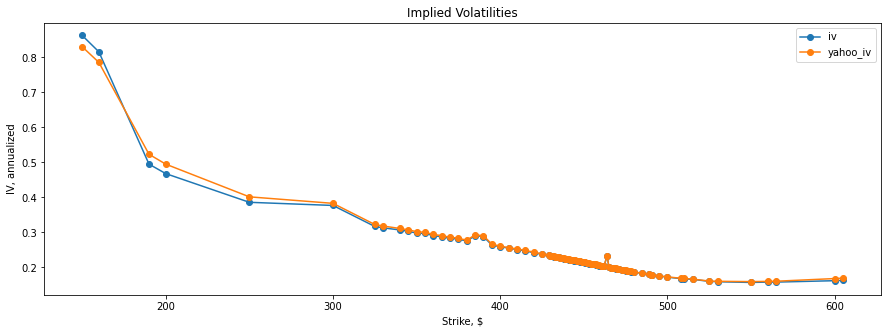

In [24]:
_, ax = plt.subplots(figsize=(15, 5))

print("Mean squared error: {:.5f}".format(np.mean((df["iv"] - df["yahoo_iv"])**2)))

for col in ("iv", "yahoo_iv"):
    ax.plot(df["strike"], df[col], "o-", label=col)
ax.legend()
ax.set_xlabel("Strike, $")
ax.set_ylabel("IV, annualized")
ax.set_title("Implied Volatilities")
plt.show()

**2. Newton Bisection Hybrid (Newt-Safe) (30 extra points)**

Implement the root finding algorithm as in https://www.youtube.com/watch?v=FD3BPTMGJds. Comment on the results and compare them with previous. 

In [25]:
#YOUR CODE HERE